In [1]:
import os
import numpy as np
import pandas as pd
import rasterio
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Conv2DTranspose, concatenate, UpSampling2D, Concatenate, LayerNormalization, MultiHeadAttention, Dense, Reshape, Multiply
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
import tensorflow.keras.backend as K
from tensorflow.keras.utils import Sequence
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import keras
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import joblib
import threading
import cv2  # OpenCV 라이브러리
from scipy.ndimage import rotate
import tifffile
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.metrics import Precision, Recall
import random
import tensorflow as tf


#데이터 설정
MAX_PIXEL_VALUE = 65535 # 이미지 정규화를 위한 픽셀 최대값

#--------------------------------------------------------------------------------------
#모델 설정
                
def TransformerEncoder(filters, num_heads, ff_dim, rate=0.1, name=None):
    inputs = Input(shape=(None, filters))
    
    # 1. Multi-Head Attention
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=filters, dropout=rate)(inputs, inputs)
    
    # 2. Add & Norm
    attention_output = Dropout(rate)(attention_output)
    attention_output = LayerNormalization(epsilon=1e-6)(inputs + attention_output)
    
    # 3. Feed Forward Network
    ffn_output = Dense(ff_dim, activation="relu")(attention_output)
    ffn_output = Dense(filters)(ffn_output)
    
    # 4. Add & Norm
    ffn_output = Dropout(rate)(ffn_output)
    outputs = LayerNormalization(epsilon=1e-6)(attention_output + ffn_output)
    
    return Model(inputs=inputs, outputs=outputs, name=name)


def conv2d_block(input_tensor, n_filters, kernel_size = 3, batchnorm = True):
    # first layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(input_tensor)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    
    # second layer
    x = Conv2D(filters=n_filters, kernel_size=(kernel_size, kernel_size), kernel_initializer="he_normal",
               padding="same")(x)
    if batchnorm:
        x = BatchNormalization()(x)
    x = Activation("relu")(x)
    return x

def transunet(nClasses, input_height=256, input_width=256, n_filters = 16, dropout = 0.1, batchnorm = True, n_channels=10):
    input_img = Input(shape=(input_height,input_width, n_channels))

    # contracting path
    c1 = conv2d_block(input_img, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    p1 = MaxPooling2D((2, 2)) (c1)
    p1 = Dropout(dropout)(p1)

    c2 = conv2d_block(p1, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)
    p2 = MaxPooling2D((2, 2)) (c2)
    p2 = Dropout(dropout)(p2)

    c3 = conv2d_block(p2, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)
    p3 = MaxPooling2D((2, 2)) (c3)
    p3 = Dropout(dropout)(p3)

    c4 = conv2d_block(p3, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)
    p4 = MaxPooling2D(pool_size=(2, 2)) (c4)
    p4 = Dropout(dropout)(p4)


    # Prepare for Transformer
    p3_flat = Reshape((16*16, 128))(p4)

    # Initialize the input for the first Transformer block
    transformer_input = p3_flat
    
        # Create a series of Transformer blocks
    for i in range(4):  # 12 Transformer blocks
        transformer_block = TransformerEncoder(
            filters=n_filters * 8, num_heads=n_filters * 8, ff_dim=n_filters * 8, rate=dropout, name=f"transformer_encoder_{i}"
        )
        transformer_output = transformer_block(transformer_input)
        transformer_input = transformer_output  # Output of the current block is the input for the next
    
    # Reshape back to the spatial dimensions for convolution
    t_encoded_reshaped = Reshape((input_height // 16, input_width // 16, n_filters * 8))(transformer_output)
    
    # expansive path
    u6 = Conv2DTranspose(n_filters*8, (3, 3), strides=(2, 2), padding='same') (t_encoded_reshaped)
    u6 = concatenate([u6, c4])
    u6 = Dropout(dropout)(u6)
    c6 = conv2d_block(u6, n_filters=n_filters*8, kernel_size=3, batchnorm=batchnorm)

    u7 = Conv2DTranspose(n_filters*4, (3, 3), strides=(2, 2), padding='same') (c6)
    u7 = concatenate([u7, c3])
    u7 = Dropout(dropout)(u7)
    c7 = conv2d_block(u7, n_filters=n_filters*4, kernel_size=3, batchnorm=batchnorm)

    u8 = Conv2DTranspose(n_filters*2, (3, 3), strides=(2, 2), padding='same') (c7)
    u8 = concatenate([u8, c2])
    u8 = Dropout(dropout)(u8)
    c8 = conv2d_block(u8, n_filters=n_filters*2, kernel_size=3, batchnorm=batchnorm)

    u9 = Conv2DTranspose(n_filters*1, (3, 3), strides=(2, 2), padding='same') (c8)
    u9 = concatenate([u9, c1], axis=3)
    u9 = Dropout(dropout)(u9)
    c9 = conv2d_block(u9, n_filters=n_filters*1, kernel_size=3, batchnorm=batchnorm)
    
    outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)
    model = Model(inputs=[input_img], outputs=[outputs])
    return model
    

def get_model(model_name, nClasses=1, input_height=128, input_width=128, n_filters=16, dropout=0.1, batchnorm=True, n_channels=10):
    return transunet(
            nClasses      = nClasses,  
            input_height  = input_height, 
            input_width   = input_width,
            n_filters     = n_filters,
            dropout       = dropout,
            batchnorm     = batchnorm,
            n_channels    = n_channels
        )

#--------------------------------------------------------------------------------------

#--------------------------------------------------------------------------------------
# 학습 설정

def lr_decay(epoch, lr):
    """
    에포크에 따라 학습률을 감소시키는 함수.
    매 epoch마다 학습률을 0.95배 해주는 예시.
    """
    decay_rate = 1
    new_lr = lr * decay_rate
    return new_lr

class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision = tf.keras.metrics.Precision()
        self.recall = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision.reset_states()
        self.recall.reset_states()

#--------------------------------------------------------------------------------------


def shuffle_lists(images_path, masks_path, random_state=None):
    # random_state가 주어진 경우, 난수 생성기의 시드를 설정합니다.
    if random_state is not None:
        random.seed(random_state)
    
    # images_path와 masks_path 리스트를 함께 섞기 위해 두 리스트의 쌍을 만듭니다.
    paired_lists = list(zip(images_path, masks_path))
    random.shuffle(paired_lists)
    
    # 섞인 리스트를 다시 분리합니다.
    shuffled_images_path, shuffled_masks_path = zip(*paired_lists)
    
    # zip() 함수는 튜플을 반환하므로, 리스트로 변환해 반환합니다.
    return list(shuffled_images_path), list(shuffled_masks_path)

# 이제 이 함수를 사용하여 이미지와 마스크 경로 리스트를 섞을 수 있습니다.
# 예시:
# images_train, masks_train = shuffle_lists(images_train, masks_train, random_state=RANDOM_STATE)
class threadsafe_iter:
    """
    데이터 불러올떼, 호출 직렬화
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def __next__(self):
        with self.lock:
            return self.it.__next__()

# 두 샘플 간의 유사성 metric
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    dice = K.mean((2. * intersection + smooth)/(union + smooth), axis=0)
    return dice

# 픽셀 정확도를 계산 metric
def pixel_accuracy (y_true, y_pred):
    sum_n = np.sum(np.logical_and(y_pred, y_true))
    sum_t = np.sum(y_true)

    if (sum_t == 0):
        pixel_accuracy = 0
    else:
        pixel_accuracy = sum_n / sum_t
    return pixel_accuracy

# 주어진 제너레이터 함수를 스레드 안전하게 만드는 데코레이터 함수
def threadsafe_generator(f):
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

# 이미지 경로에서 이미지를 읽어와 정규화한 후 numpy 배열로 반환
def get_img_arr(path):
    img = rasterio.open(path).read().transpose((1, 2, 0))
    img = np.float32(img)/MAX_PIXEL_VALUE

    return img

# 마스크 이미지 경로에서 이미지를 읽어와 numpy 배열로 반환
def get_mask_arr(path):
    img = rasterio.open(path).read().transpose((1, 2, 0))
    seg = np.float32(img)
    return seg


# 데이터 불러오는 함수
@threadsafe_generator
def generator_from_lists(images_path, masks_path, batch_size=32, shuffle = True, random_state=None, image_mode='10bands'):

    images = []
    masks = []

    fopen_image = get_img_arr
    fopen_mask = get_mask_arr

    i = 0
    # 데이터 shuffle
    while True:

        if shuffle:
            if random_state is None:
                images_path, masks_path = shuffle_lists(images_path, masks_path)
            else:
                images_path, masks_path = shuffle_lists(images_path, masks_path, random_state= random_state + i)
                i += 1


        for img_path, mask_path in zip(images_path, masks_path):

            img = fopen_image(img_path)
            mask = fopen_mask(mask_path)
            images.append(img)
            masks.append(mask)

            if len(images) >= batch_size:
                yield (np.array(images), np.array(masks))
                images = []
                masks = []

# 모델에 들어가는 data pre-processing
class DataGenerator(Sequence):
    def __init__(self, img_paths, mask_paths, batch_size=32, default_path=None):
        self.img_paths = img_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.default_path = default_path if default_path else ""

    def __len__(self):
        return len(self.img_paths) // self.batch_size

    def __getitem__(self, idx):
        batch_img_paths = self.img_paths[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_mask_paths = self.mask_paths[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_imgs = []
        batch_masks = []
        
        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            img = tifffile.imread(os.path.join(self.default_path, 'train_img', img_path))
            mask = tifffile.imread(os.path.join(self.default_path, 'train_mask', mask_path))

            # # 이미지를 uint8 타입으로 변환 (히스토그램 평활화를 위해 필요)
            # img = np.clip(img / MAX_PIXEL_VALUE * 255.0, 0, 255).astype(np.uint8)

            # 수평 뒤집기를 25% 확률로 적용
            if random.random() < 0.25:
                img = np.fliplr(img)
                mask = np.fliplr(mask)
            
            # 수직 뒤집기를 25% 확률로 적용
            if random.random() < 0.25:
                img = np.flipud(img)
                mask = np.flipud(mask)
            
            # # 히스토그램 평활화 적용
            # img = np.array([cv2.equalizeHist(channel) for channel in img.transpose((2, 0, 1))]).transpose((1, 2, 0))

            # 이미지를 다시 float32 타입으로 변환하고 정규화
            img = img.astype(np.float32) / MAX_PIXEL_VALUE

            mask = mask.astype(np.float32)  # 마스크의 정규화를 변경하지 않음

            batch_imgs.append(img)
            batch_masks.append(mask)

        return np.array(batch_imgs), np.array(batch_masks)
# 시각화

# 이미지 로딩 함수 (가정)
def get_img_arr(image_path):
    # 이 함수는 이미지 파일 경로를 받아 해당 이미지의 배열을 반환합니다.
    # 실제 구현은 프로젝트에 따라 다를 수 있습니다.
    # 여기서는 간단한 예시로 rasterio를 사용한 구현을 가정합니다.
    import rasterio
    with rasterio.open(image_path) as src:
        img = src.read()
        img = np.transpose(img, (1, 2, 0))  # 채널 순서 조정
    return img

# 특정 이미지에 대한 예측 마스크 시각화 함수
def visualize_prediction(test_image_name):
    # 테스트 이미지 로딩
    img = get_img_arr(f'./AIspark_dataset/test_img/{test_image_name}')
    
    # 예측된 마스크 로딩
    y_pred = y_pred_dict[test_image_name]
    
    # 이미지와 예측된 마스크 시각화
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].imshow(img[:, :, 0], cmap='gray')  # 첫 번째 채널을 그레이스케일 이미지로 시각화
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(y_pred, cmap='gray')  # 예측된 마스크 시각화
    axs[1].set_title('Predicted Mask')
    axs[1].axis('off')

    plt.show()

def load_tif_image(image_path):
    with rasterio.open(image_path) as img_file:
        img = img_file.read()
    return np.transpose(img, (1, 2, 0))

def visualize_channel_images(image):
    channels = image.shape[2]
    plt.figure(figsize=(20, 10))
    for i in range(channels):
        plt.subplot(2, (channels+1)//2, i+1)
        plt.imshow(image[:, :, i])
        plt.title(f'Channel {i+1}')
        plt.axis('off')
    plt.show()




2024-03-18 06:03:59.764748: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-18 06:03:59.788982: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-18 06:03:59.789014: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-18 06:03:59.789030: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-18 06:03:59.794109: I tensorflow/core/platform/cpu_feature_g

In [2]:

# 사용할 데이터의 meta정보 가져오기

train_meta = pd.read_csv('/home/jskim/aispark/AIspark_dataset/train_meta.csv')
test_meta = pd.read_csv('/home/jskim/aispark/AIspark_dataset/test_meta.csv')


# 저장 이름
save_name = 'base_line'

N_FILTERS = 16 # 필터수 지정
N_CHANNELS = 10 # channel 지정
EPOCHS = 30 # 훈련 epoch 지정
BATCH_SIZE = 32 # batch size 지정
IMAGE_SIZE = (256, 256) # 이미지 크기 지정
# MODEL_NAME = 'unet' # 모델 이름
MODEL_NAME = 'Tnet' # 모델 이름
RANDOM_STATE = 42 # seed 고정
INITIAL_EPOCH = 0 # 초기 epoch

# 데이터 위치
IMAGES_PATH = '/home/jskim/aispark/AIspark_dataset/train_img'
MASKS_PATH = '/home/jskim/aispark/AIspark_dataset/train_mask'

# 가중치 저장 위치
OUTPUT_DIR = '/home/jskim/aispark/train_output/'
WORKERS = 64

# 조기종료
EARLY_STOP_PATIENCE = 5

# 중간 가중치 저장 이름
CHECKPOINT_PERIOD = 5
CHECKPOINT_MODEL_NAME = 'checkpoint-{}-{}-epoch_{{epoch:02d}}.hdf5'.format(MODEL_NAME, save_name)

# 최종 가중치 저장 이름
FINAL_WEIGHTS_OUTPUT = 'model_{}_{}_final_weights.h5'.format(MODEL_NAME, save_name)

# 사용할 GPU 이름
CUDA_DEVICE = 1


# 저장 폴더 없으면 생성
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

# GPU 설정
os.environ["CUDA_VISIBLE_DEVICES"] = str(CUDA_DEVICE)
try:
    config = tf.compat.v1.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.compat.v1.Session(config=config)
    K.set_session(sess)
except:
    pass

try:
    np.random.bit_generator = np.random._bit_generator
except:
    pass

# train : val = 8 : 2 나누기
x_tr, x_val = train_test_split(train_meta, test_size=0.2, random_state=RANDOM_STATE)
print(len(x_tr), len(x_val))

# train : val 지정 및 generator
images_train = [os.path.join(IMAGES_PATH, image) for image in x_tr['train_img'] ]
masks_train = [os.path.join(MASKS_PATH, mask) for mask in x_tr['train_mask'] ]

images_validation = [os.path.join(IMAGES_PATH, image) for image in x_val['train_img'] ]
masks_validation = [os.path.join(MASKS_PATH, mask) for mask in x_val['train_mask'] ]

train_generator = generator_from_lists(images_train, masks_train, batch_size=BATCH_SIZE, random_state=RANDOM_STATE)
validation_generator = generator_from_lists(images_validation, masks_validation, batch_size=BATCH_SIZE, random_state=RANDOM_STATE, image_mode="762")

# model 불러오기
model = get_model(MODEL_NAME, input_height=IMAGE_SIZE[0], input_width=IMAGE_SIZE[1], n_filters=N_FILTERS, n_channels=N_CHANNELS)
model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()


# 콜백 정의 (ModelCheckpoint에서 monitor 대상 변경)
es = EarlyStopping(monitor='loss', mode='min', verbose=1, patience=EARLY_STOP_PATIENCE)  # 'val_loss' 대신 'loss' 사용
checkpoint = ModelCheckpoint(os.path.join(OUTPUT_DIR, CHECKPOINT_MODEL_NAME), monitor='loss', verbose=1, save_best_only=True, mode='auto', save_freq='epoch')  # 'val_accuracy' 대신 'loss' 모니터링, `period` 대신 `save_freq` 사용
lr_scheduler = LearningRateScheduler(lr_decay)

print('---model 훈련 시작---')
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(images_train) // BATCH_SIZE,
    validation_data=validation_generator,
    validation_steps=len(images_validation) // BATCH_SIZE,
    callbacks=[checkpoint, es],
    epochs=EPOCHS,
    workers=WORKERS,
    initial_epoch=INITIAL_EPOCH
)
print('---model 훈련 종료---')

print('가중치 저장')
model_weights_output = os.path.join(OUTPUT_DIR, FINAL_WEIGHTS_OUTPUT)
model.save_weights(model_weights_output)
print("저장된 가중치 명: {}".format(model_weights_output))

# 제출용 pkl 파일 만들기
model = get_model(MODEL_NAME, input_height=IMAGE_SIZE[0], input_width=IMAGE_SIZE[1], n_filters=N_FILTERS, n_channels=N_CHANNELS)
model.compile(optimizer = Adam(), loss = 'binary_crossentropy', metrics = ['accuracy'])
model.summary()

model.load_weights('/home/jskim/aispark/train_output/model_Tnet_base_line_final_weights.h5')

y_pred_dict = {}

2024-03-18 06:04:08.033062: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46285 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:61:00.0, compute capability: 8.9
2024-03-18 06:04:08.091646: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1886] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 46285 MB memory:  -> device: 0, name: NVIDIA RTX 6000 Ada Generation, pci bus id: 0000:61:00.0, compute capability: 8.9


26860 6715
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 10)]       0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         1456      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 256, 256, 16)         64        ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 256, 256, 16)         0         ['batch_normali

2024-03-18 06:04:13.441363: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-03-18 06:04:14.243550: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8800
2024-03-18 06:04:14.332104: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:231] Falling back to the CUDA driver for PTX compilation; ptxas does not support CC 8.9
2024-03-18 06:04:14.332151: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:234] Used ptxas at ptxas
2024-03-18 06:04:14.332258: W tensorflow/compiler/xla/stream_executor/gpu/redzone_allocator.cc:322] UNIMPLEMENTED: ptxas ptxas too old. Falling back to the driver to compile.
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2024-03-18 06:04:15.09324

839/839 [==============================] - ETA: 0s - loss: 0.0673 - accuracy: 0.9962
Epoch 1: loss improved from inf to 0.06725, saving model to /home/jskim/aispark/train_output/checkpoint-Tnet-base_line-epoch_01.hdf5
839/839 [==============================] - 418s 480ms/step - loss: 0.0673 - accuracy: 0.9962 - val_loss: 0.0095 - val_accuracy: 0.9997
Epoch 2/30
839/839 [==============================] - ETA: 0s - loss: 0.0045 - accuracy: 0.9997
Epoch 2: loss improved from 0.06725 to 0.00449, saving model to /home/jskim/aispark/train_output/checkpoint-Tnet-base_line-epoch_02.hdf5
839/839 [==============================] - 402s 479ms/step - loss: 0.0045 - accuracy: 0.9997 - val_loss: 0.0023 - val_accuracy: 0.9998
Epoch 3/30
839/839 [==============================] - ETA: 0s - loss: 0.0015 - accuracy: 0.9999
Epoch 3: loss improved from 0.00449 to 0.00152, saving model to /home/jskim/aispark/train_output/checkpoint-Tnet-base_line-epoch_03.hdf5
839/839 [==============================] - 402

1/1 [==============================] - 0s 15ms/step


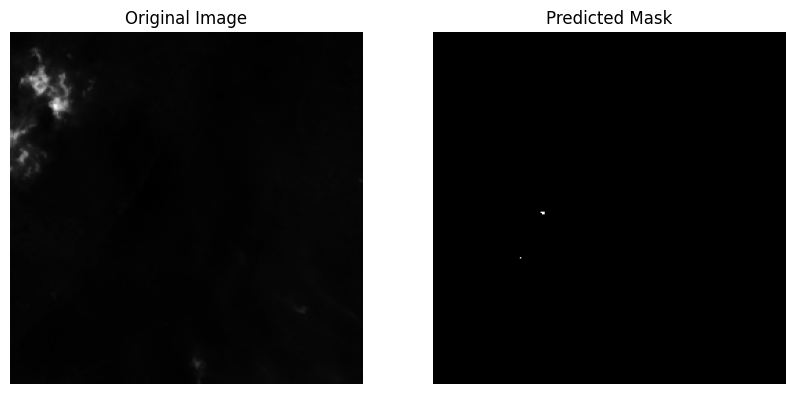

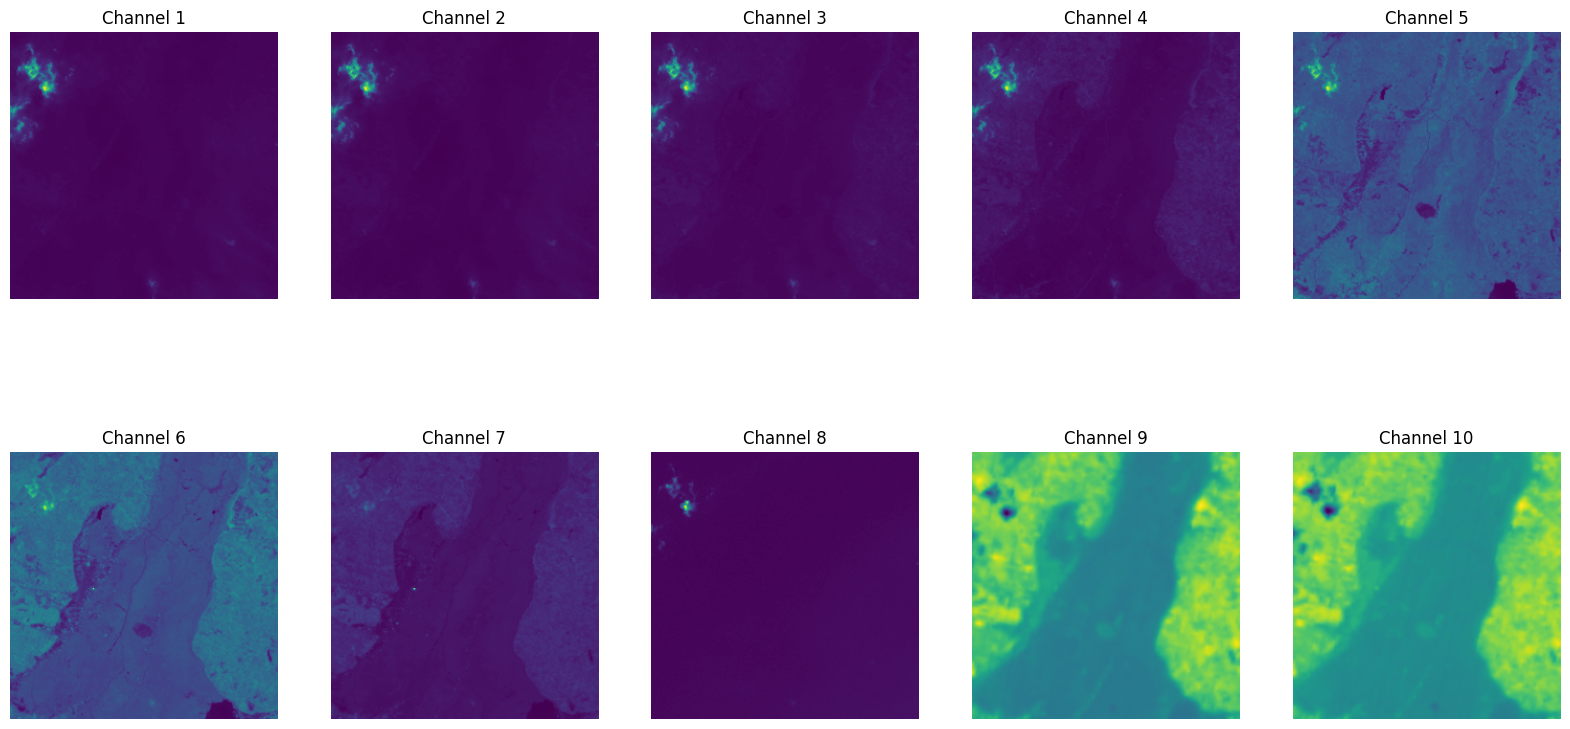

In [3]:
for i in test_meta['test_img']:
    img =  get_img_arr(f'/home/jskim/aispark/AIspark_dataset/test_img/{i}')
    y_pred = model.predict(np.array([img]), batch_size=1)

    y_pred = np.where(y_pred[0, :, :, 0] > 0.25, 1, 0) # 임계값 처리
    y_pred = y_pred.astype(np.uint8)
    y_pred_dict[i] = y_pred

joblib.dump(y_pred_dict, '/home/jskim/aispark/y_pred.pkl')

# 시각화
# 예측 결과 딕셔너리 로드
y_pred_dict = joblib.load('/home/jskim/aispark/y_pred.pkl')

# 예시: 'test_img_2427.tif' 이미지에 대한 예측 마스크 시각화
visualize_prediction('test_img_2423.tif')
image_path = '/home/jskim/aispark/AIspark_dataset/test_img/test_img_2423.tif'
visualize_channel_images(load_tif_image(image_path))